# 客户流失预测Sparkify 项目
根据音乐类服务的用户行为数据集对数据进行清洗、探索性分析并利用机器学习算法进行可能的客户流失的预测。

## 数据结构
- artist：歌手
- auth:登录状态，可能的取值为Logged Out,Cancelled,Guest,Logged In
- gender:性别，可能的取值为F和M
- level:会员等级，可能的取值为free和paid
- page:请求页面，可能的取值为Cancel,Submit Downgrade,Thumbs Down,Home,Roll Advert,Logout,Save Settings,Cancellation Confirmation,About,Submit Registration,Settings,Login,Register,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade
- registration:注册时间
- sessionId:
- song:歌名
- status:可能取值为202，400，307
- ts:
- userAgent:用户使用设备
- userId:用户ID

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, isnull, udf, from_unixtime, unix_timestamp, when, col
from pyspark.sql.types import StringType, IntegerType, DateType, TimestampType, LongType
from pyspark.ml.feature import  VectorAssembler, Normalizer, StandardScaler, MinMaxScaler

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import time

plt.style.use('ggplot')

In [2]:
# create a Spark session
spark = SparkSession.builder\
        .appName("Sparkify")\
        .getOrCreate()

# 加载和清洗数据

加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

## 质量问题：
- userId中存在空值，删除userId为空的数据
- registration和ts数据类型应该是时间
- userAgent代表了用户使用的设备，可以提取设备信息

In [3]:
df_event = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df_event.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# 查看数据总数
df_event.count()

286500

In [6]:
df_event.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [7]:
# 查看userId为空的用户数
df_event.filter(df_event.userId == "").count()

8346

In [8]:
df_event.select('sessionId').dropDuplicates().sort('sessionId').show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [9]:
df_event.filter(isnull(df_event.sessionId)).count()

0

In [10]:
df_event.filter(isnan(df_event.sessionId)).count()

0

In [11]:
print(df_event.filter(isnan(df_event.ts)).count())

0


## 问题1：userId中存在空值

### 代码

In [4]:
df_cleaned_event = df_event.filter(df_event.userId != "")

### 测试

In [13]:
df_cleaned_event.filter(df_cleaned_event.userId == "").count()

0

## 问题2：registration和ts数据类型应该是时间

### 代码

In [5]:
# 将ts和registration各行数据都除以1000，单位转化为毫秒
to_time = udf(lambda x: x//1000)
df_cleaned_event = df_cleaned_event.withColumn(\
        "ts", to_time(df_cleaned_event.ts))
df_cleaned_event = df_cleaned_event.withColumn(\
        "registration", to_time(df_cleaned_event.registration))

# 将数据类型转化为TimestampType
df_cleaned_event = df_cleaned_event.withColumn("ts", \
                                               from_unixtime("ts").cast(TimestampType()))
df_cleaned_event = df_cleaned_event.withColumn("registration",\
                                               from_unixtime("registration").cast(TimestampType()))

### 测试

In [15]:
df_cleaned_event.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: timestamp (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## 问题3：userAgent代表了用户使用的设备，可以提取设备信息

### 代码

In [6]:
get_device = udf(lambda x: x.split("(")[1].split(")")[0].split(";")[0].split(" ")[0])
df_cleaned_event = df_cleaned_event.withColumn("device", \
                                               get_device(df_cleaned_event.userAgent))

### 测试

In [17]:
df_cleaned_event.select(["device"]).distinct().show()

+----------+
|    device|
+----------+
|      iPad|
|       X11|
|    iPhone|
| Macintosh|
|compatible|
|   Windows|
+----------+



# 探索性数据分析

### 定义客户流失

完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
定义好客户流失后，可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。
- 观察流失用户的数量分布和相关因素间关系
    - 留存用户和流失用户占比
    - 流失用户和Level、gender、device间的关系  
- 观察流失用户的特定动作出现的数量之间的关系
    - Next Song，Thumbs Down，Thumbs Up，Roll Advert、Downgrade、Add Friend、Add to Playlist、Upgrade等动过出现的次数
    - 听过的歌曲数目、听过的艺术家的数目

In [7]:
# 寻找流失客户ID
churn_userId = df_cleaned_event.filter(\
        df_cleaned_event.page == "Cancellation Confirmation").toPandas()\
            .drop_duplicates(subset = "userId")["userId"]
churn_userId = list(churn_userId)

# 添加churn标签，标记客户流失
churn_event = udf(lambda x: 1 if x in churn_userId else 0, IntegerType())
df_cleaned_event = df_cleaned_event.withColumn(\
        "churn", churn_event(df_cleaned_event.userId))

In [8]:
# 只要用户曾经付费便是付费用户,获取付费用户
paid_userId = df_cleaned_event.filter(\
    df_cleaned_event.level == "paid").toPandas()\
        .drop_duplicates(subset = "userId")["userId"]
paid_userId = list(paid_userId)

paid_event = udf(lambda x : "paid" if x in paid_userId else "free")
df_cleaned_event = df_cleaned_event.withColumn(\
        "level", paid_event(df_cleaned_event.userId))

#### 观察流失用户的数量分布和相关因素间关系

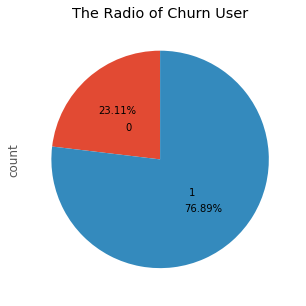

In [20]:
count_by_chrun = df_cleaned_event.select(["userId", "churn"])\
        .dropDuplicates(["userId"])\
        .groupby("churn").count().toPandas()
# 控制显示的圆为正圆
plt.axes(aspect = 'equal')
count_by_chrun["count"].plot.pie(
    startangle = 90,\
    wedgeprops = {'linewidth': 2},
    autopct='%.2f%%',
    title = "The Radio of Churn User",
    pctdistance = 0.6,
    figsize = (5,5),
    labeldistance=0.4);

In [21]:
# 统计注销用户和非注销用户在性别和会员等级间关系
df_churn_user_info = df_cleaned_event\
        .select(["userId", "gender", "level", "churn", "device"])\
        .dropDuplicates(subset = ["userId", "gender"]).toPandas()

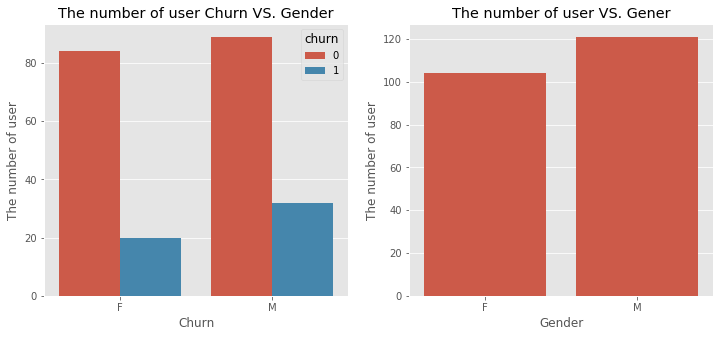

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.countplot(x = "gender", hue = "churn",
              data=df_churn_user_info)
plt.title("The number of user Churn VS. Gender")
plt.xlabel("Churn")
plt.ylabel("The number of user");

plt.subplot(122)
sns.countplot(x = "gender", 
              data = df_churn_user_info,
              color = sns.color_palette()[0])
plt.title("The number of user VS. Gener")
plt.xlabel("Gender")
plt.ylabel("The number of user");

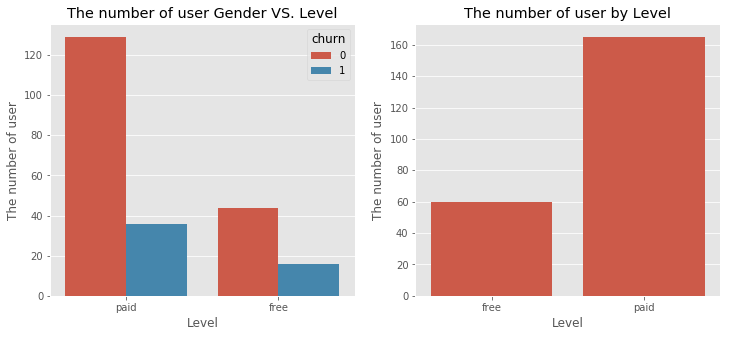

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.countplot(x = "level", hue = "churn", 
              data = df_churn_user_info)
plt.title("The number of user Gender VS. Level")
plt.xlabel("Level")
plt.ylabel("The number of user");

plt.subplot(122)
sns.countplot(x = "level", 
              data = df_churn_user_info,
              color = sns.color_palette()[0],
              order = ["free", "paid"])
plt.title("The number of user by Level")
plt.xlabel("Level")
plt.ylabel("The number of user");

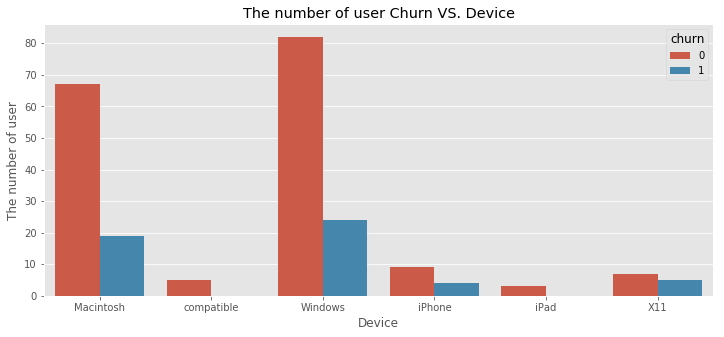

In [24]:
plt.figure(figsize=(12, 5))
sns.countplot(x = "device", hue = "churn",
              data=df_churn_user_info)
plt.title("The number of user Churn VS. Device")
plt.xlabel("Device")
plt.ylabel("The number of user");

通过上面的图表可以看出：
- 流失用户占比低于留存用户，占比分别为23.11%和76.89%
- 流失用户中男性的绝对人数和比例均大于女性。
- 流失用户中付费用户的绝对数量大于免费用户，而无论是付费还是免费留存用户都占据绝大多数。
- 用户大多数通过Mac和Windows访问，其中使用Windows流失客户的绝对数量最大，其次是Mac，同时使用X11客户中流失客户的比例最高，其次是iPhone。

#### 观察流失用户的特定动作出现的数量之间的关系
- Next Song，Thumbs Down，Thumbs Up，Roll Advert、Downgrade、Add Friend、Add to Playlist、Upgrade等动过出现的次数
- 听过的歌曲数目、听过的艺术家的数目

In [9]:
# 过滤出流失客户ID
churn_userId = df_cleaned_event.filter(\
        df_cleaned_event.page == "Cancellation Confirmation").toPandas()\
            .drop_duplicates(subset = "userId")["userId"]
churn_userId = list(churn_userId)

# 查找出唯一客户ID
df_churn_event = df_cleaned_event.select("userId").distinct()

# 定义流失事件
churn_event = udf(lambda x : 1 if x in churn_userId else 0, IntegerType())
df_churn_event = df_churn_event.withColumn(
            "churn", churn_event(df_churn_event.userId))

In [10]:
# 匹配客户的gender和level信息
df_gender_level = df_cleaned_event.select(["userId", "gender", "level"])\
        .drop_duplicates(subset = ["userId", "gender"])
df_churn_event = df_churn_event.join(df_gender_level, "userId", "outer")

In [11]:
# 统计访问各个页面的次数
for item in df_cleaned_event.select("page").distinct().collect():
    action, col_name = item[0], item[0].lower().replace(" ", "_")
    df_action = df_cleaned_event.filter(df_cleaned_event.page == action)\
        .select("userId")\
        .groupBy("userId")\
        .agg({"userId" : "count"})\
        .withColumnRenamed("count(userId)", col_name)
    df_action.fillna(0)
    df_churn_event= df_churn_event.join(df_action, on = "userId", how = "left")

In [12]:
# 统计用户听过的歌手和歌曲的数量
for item in ["artist", "song"]:
    df_item = df_cleaned_event.filter(df_cleaned_event.page == "NextSong")\
        .select(['userId', item])\
        .dropDuplicates()\
        .groupBy("userId")\
        .agg({item : "count"})\
        .withColumnRenamed("count(" + item + ")", item) # 列名重名
    df_churn_event = df_churn_event.join(df_item, on = "userId")

In [13]:
# 用户访问出错的次数
df_errors = df_cleaned_event.filter(df_cleaned_event.status == 404)\
        .select(['userId', "status"])\
        .groupBy("userId")\
        .agg({"status" : "count"})\
        .withColumnRenamed("count(status)", "num_error") # 列名重名
df_churn_event = df_churn_event.join(df_errors, on = "userId")

In [14]:
# 用0替换NAN
df_churn_event = df_churn_event.fillna(0)

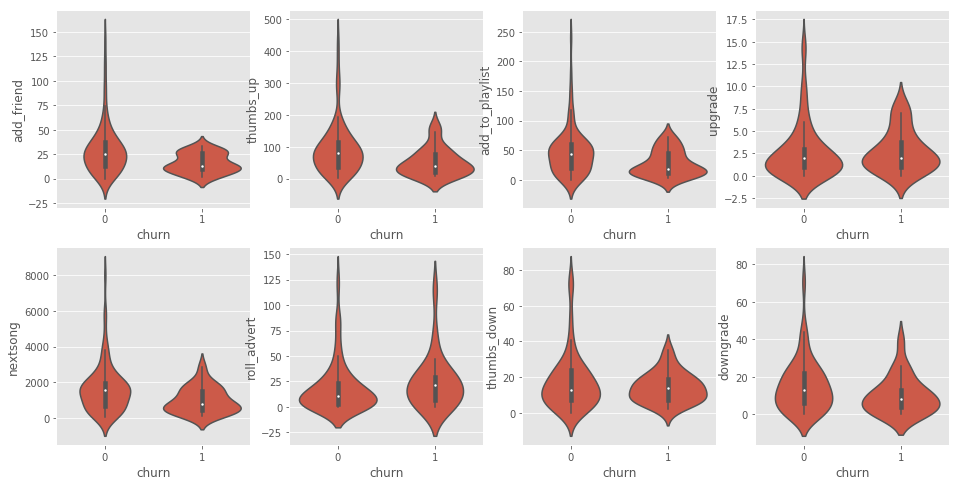

In [32]:
# 将数据转化为Pandas DataFrame格式
df_churn_event0 = df_churn_event.toPandas()
plt.figure(figsize=(16,8))
plt.subplot(241)
sns.violinplot(data=df_churn_event0, x = "churn", y = "add_friend", \
               color = sns.color_palette()[0])

plt.subplot(242)
sns.violinplot(data=df_churn_event0, x = "churn", y = "thumbs_up", \
               color = sns.color_palette()[0])

plt.subplot(243)
sns.violinplot(data=df_churn_event0, x = "churn", y = "add_to_playlist", \
               color = sns.color_palette()[0])

plt.subplot(244)
sns.violinplot(data=df_churn_event0, x = "churn", y = "upgrade", \
               color = sns.color_palette()[0])

plt.subplot(245)
sns.violinplot(data=df_churn_event0, x = "churn", y = "nextsong", \
               color = sns.color_palette()[0])

plt.subplot(246)
sns.violinplot(data=df_churn_event0, x= "churn", y = "roll_advert", \
               color = sns.color_palette()[0])

plt.subplot(247)
sns.violinplot(data=df_churn_event0, x = "churn", y = "thumbs_down", \
               color = sns.color_palette()[0])

plt.subplot(248)
sns.violinplot(data=df_churn_event0, x = "churn", y = "downgrade", \
               color = sns.color_palette()[0]);

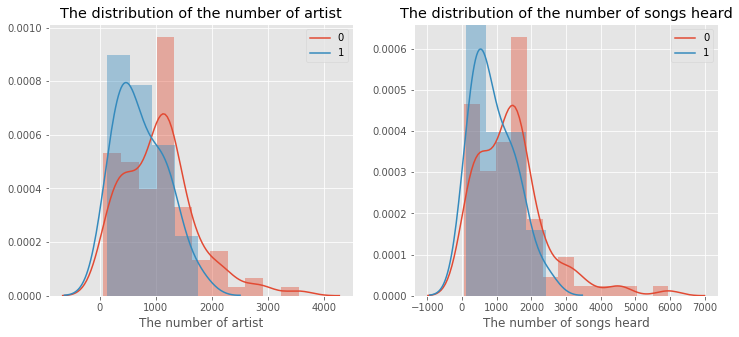

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df_churn_event0[df_churn_event0.churn == 0].artist, \
             color = sns.color_palette()[0],\
             kde_kws ={"label": "0"})
sns.distplot(df_churn_event0[df_churn_event0.churn == 1].artist, \
             color = sns.color_palette()[1], \
             kde_kws ={"label": "1"})
plt.title("The distribution of the number of artist")
plt.xlabel("The number of artist")

plt.subplot(122)
sns.distplot(df_churn_event0[df_churn_event0.churn == 0].song, \
            color = sns.color_palette()[0],\
            kde_kws ={"label": "0"})
sns.distplot(df_churn_event0[df_churn_event0.churn == 1].song, \
             color = sns.color_palette()[1],\
            kde_kws ={"label": "1"})
plt.title("The distribution of the number of songs heard")
plt.xlabel("The number of songs heard");

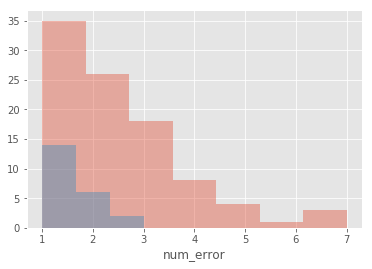

In [34]:
sns.distplot(df_churn_event0[df_churn_event0.churn == 0].num_error, \
             kde = False, color = sns.color_palette()[0], hist_kws={"label" : "0"})
sns.distplot(df_churn_event0[df_churn_event0.churn == 1].num_error, 
             kde = False, color = sns.color_palette()[1], hist_kws={"label" : "1"});

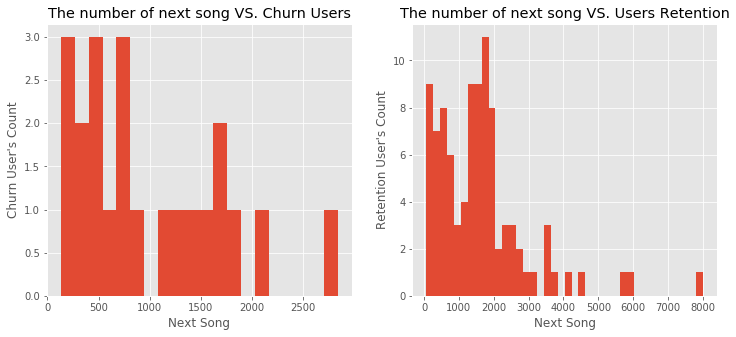

In [35]:
plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121)
df_churn = df_churn_event.toPandas()
df_churn_1 = df_churn[df_churn.churn == 1]
df_churn_1["nextsong"].hist(bins = 20)
plt.title("The number of next song VS. Churn Users")
plt.xlabel("Next Song")
plt.ylabel("Churn User's Count")

plt.subplot(122)
df_churn_0 = df_churn[df_churn.churn == 0]
df_churn_0["nextsong"].hist(bins = 40)
plt.title("The number of next song VS. Users Retention")
plt.xlabel("Next Song")
plt.ylabel("Retention User's Count");

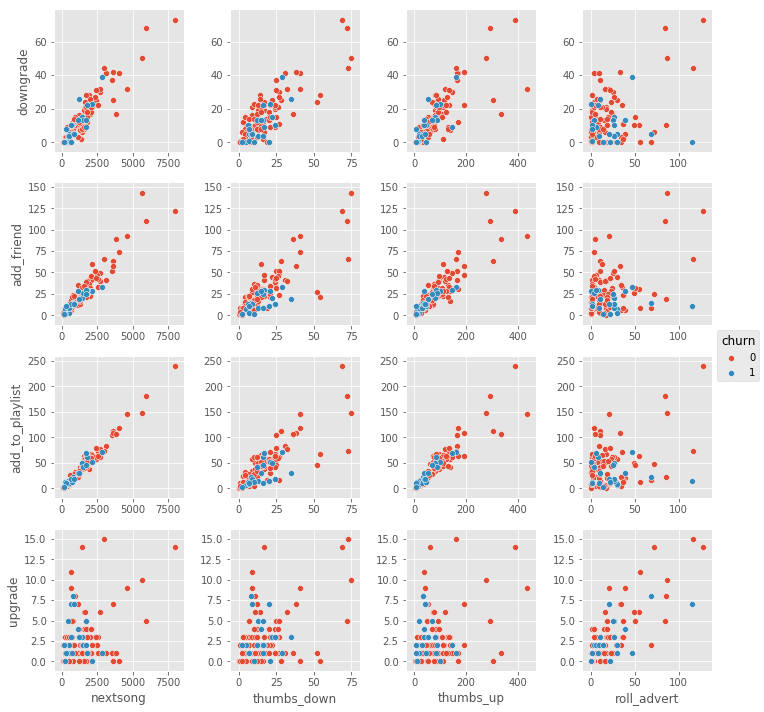

In [36]:
sns.pairplot(data = df_churn_event.toPandas(), \
             x_vars = ["nextsong", "thumbs_down", "thumbs_up","roll_advert"],\
             y_vars = ["downgrade", "add_friend", "add_to_playlist", "upgrade"], \
             hue = "churn");

通过上图，我们可以观察流失用户的特定动作出现的数量之间的关系：
- 相较于留存用户，发生Add Frind、Thumbs Up、Add to Playlist、NextSong、Thumbs Down动作次数相对较少，且数据分布相对集中，同时Upgrade、Roll Advert、Downgrade的次数差别相对不太明显。
- 相比于留存用户流失用户听的艺术家数和歌曲数目相对较少。
- 出现错误的次数较少，错误次数对留存率没有明显的相关性。
- 从整体上可以看大，流失用户在页面发生动作的次数要低于留存用户，特别地，流失用户发出Next Song、Thumbs UP、Add to Playlist、Add Friend等动作的次数要明显少于留存用户。同时也可以看到产生Next Song动作次数与Add to Playlist、Add Friend、Downgrade动作次数具有明显的正相关性，Thumbs Up动作产生的次数与Add to Playlist、Add Friend、Downgrade动作次数也有明显的正相关性。

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

构建数据特征，数据由userId，level，性别，访问各个页面的次数。

In [15]:
#将level中的paid和free分别用1和0替换
onehot_level = udf(lambda x : 1 if x == "paid" else 0, LongType())
df_churn_event = df_churn_event.withColumn(
        "level", onehot_level(df_churn_event.level))

In [59]:
features_cols = ["nextsong", "thumbs_down", "thumbs_up", \
                 "roll_advert", "downgrade", "add_friend", \
                 "add_to_playlist", "upgrade", "cancel", "help"]
feactures_assembler = VectorAssembler(inputCols = features_cols,\
                                      outputCol = "vector_features")
df_feature = feactures_assembler.transform(df_churn_event)
min_max_scaler = MinMaxScaler(inputCol="vector_features", \
                              outputCol = "features")
df_feature_scaled = min_max_scaler.fit(df_feature)\
                        .transform(df_feature)

In [60]:
# 将churn改名为label
df_feature_scaled = df_feature_scaled.withColumnRenamed("churn", "label")

In [61]:
df_feature_scaled = df_feature_scaled.select("features", "label")

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [40]:
df_feature_scaled.count()

117

In [62]:
# 将数据划分为训练集、数据集和训练集
df_train, df_val, df_test = df_feature_scaled.randomSplit([0.6, 0.2, 0.2], seed = 42)

In [19]:
print(df_train.count(), df_val.count(), df_test.count())

142 49 34


本实验为了预测客户的流失率，目标是尽可能准确地识别出可能流失的客户，可以使用准确率来对模型进行评估。本实验数据集中共有117个客户数据， 142个训练数据，49个验证数据，34个测试数据，在上面的数据探索分析中可以看到数据集中留存客户的占比为76.89%，留存客户比例远大于流失客户，数据分布呈斜分布。

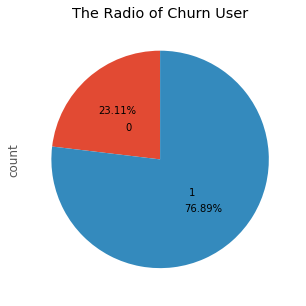

In [43]:
count_by_chrun = df_cleaned_event.select(["userId", "churn"])\
        .dropDuplicates(["userId"])\
        .groupby("churn").count().toPandas()
# 控制显示的圆为正圆
plt.axes(aspect = 'equal')
count_by_chrun["count"].plot.pie(
    startangle = 90,\
    wedgeprops = {'linewidth': 2},
    autopct='%.2f%%',
    title = "The Radio of Churn User",
    pctdistance = 0.6,
    figsize = (5,5),
    labeldistance=0.4);

在这种情况下，假设天真地预测模型结果均为0(都为留存客户),此时模型的准确率可以接近80%，可见因此精度不适合最评估指标。而采用召回率或者F1 Score更加适合，本数据集中流失客户很少，F1 Score结合精度和召回率，更适合做评估指标

## 模型选择

### 随机森林

#### 调整的参数
- maxDepth可能取值有3,5

In [67]:
# 创建模型
classifier = RandomForestClassifier(seed = 42)
#网格搜索
        #.addGrid(classifier.numTrees, [3,5])\
paramGridBuilder = ParamGridBuilder()\
        .addGrid(classifier.maxDepth, [3, 5])\
        .build()
#评分器
evaluator = MulticlassClassificationEvaluator(metricName="f1")

#交叉验证
crossValidator = CrossValidator(estimator = classifier,\
                                estimatorParamMaps = paramGridBuilder,\
                                evaluator = evaluator,
                                numFolds = 2)

In [69]:
num_iter = 1
f1_train, f1_val = [], []
for epoch in range(num_iter):
    # 记录开始训练的时间
    start_time = time.time()
    model = crossValidator.fit(df_train)
    # 训练模型耗时
    time_train = time.time() - start_time
    train_result = model.transform(df_train)
    val_result = model.transform(df_val)
    f1_train.append(evaluator.evaluate(train_result, \
                                       {evaluator.metricName:"f1"}))
    f1_val.append(evaluator.evaluate(val_result, \
                                     {evaluator.metricName:"f1"}))

In [70]:
results_test = model.transform(df_test)
print('Cost time on Training :{}'.format(time_train))
start = time.time()
print('Accuracy on Test:{}'.format(evaluator.evaluate(\
    results_test,{evaluator.metricName:"accuracy"})))
print('F-1 Score on Test:{}'.format(evaluator.evaluate(\
    results_test,{evaluator.metricName:"f1"})))
print('Cost time on Test Set :{}'.format(time.time() - start))

Cost time on Training :720.4316155910492
Accuracy on Test:1.0
F-1 Score on Test:1.0
Cost time on Test Set :213.84380054473877


#### 评估得分
- 准确度：100%
- F-1 Score:1.0
- 训练耗时：720.43s
- 在测试集上预测耗时：213.84s

In [71]:
# 查看特征重要性
model.bestModel.featureImportances

SparseVector(10, {0: 0.029, 1: 0.0297, 2: 0.0426, 3: 0.0203, 4: 0.0363, 5: 0.0305, 6: 0.0665, 7: 0.0005, 8: 0.7107, 9: 0.0338})

In [72]:
# 查看最佳参数
model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)]

{Param(parent='RandomForestClassifier_3a81d0ec7787', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3}

#### 最佳参数
|参数|值|说明|
|:--:|:--:|:--:|
|maxDepth|5|树的最大深度|
|numTrees|5|要训练的树的数量|

In [75]:
def show_feature_importance(model, features_cols):
    '''可视化特征的主要性

    @param:
        model:机器学习模型
        df:   包含数据特征的DataFrame
    '''
    
    importances = model.bestModel.featureImportances
    #对特征重要性排序
    indices = np.argsort(importances)[::-1]
    sorted_importances = [importances[int(i)] for i in indices]
    # 获取特征的名字
    names = [features_cols[i] for i in indices]

    plt.figure(figsize=(12,5))
    plt.title("Features' importance")
    plt.bar(range(len(features_cols)), sorted_importances)
    plt.xticks(range(len(features_cols)), names, rotation=15)
    plt.show()
    for i in range(len(indices)):
        print("feature: {}, importance: {}".format(names[i], sorted_importances[i]) )     

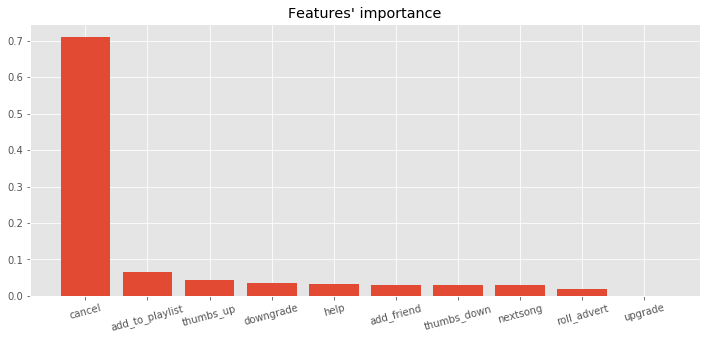

feature: cancel, importance: 0.7106571312017078
feature: add_to_playlist, importance: 0.06646295279161701
feature: thumbs_up, importance: 0.04264234877010087
feature: downgrade, importance: 0.03634376583006884
feature: help, importance: 0.033825375728498294
feature: add_friend, importance: 0.030547151433165266
feature: thumbs_down, importance: 0.02967892361283288
feature: nextsong, importance: 0.028964543392349294
feature: roll_advert, importance: 0.020333858434841392
feature: upgrade, importance: 0.0005439488048183546


In [76]:
show_feature_importance(model, features_cols)

### 逻辑回归模型
#### 调整的参数
- maxIter可能取值有3，5

In [64]:
# 创建模型
classifier = LogisticRegression()
#网格搜索
paramGridBuilder = ParamGridBuilder()\
        .addGrid(classifier.maxIter, [3, 5])\
        .build()
#评分器
evaluator = MulticlassClassificationEvaluator(metricName="f1")

#交叉验证
crossValidator = CrossValidator(estimator = classifier,\
                                estimatorParamMaps = paramGridBuilder,\
                                evaluator = evaluator,
                                numFolds = 2)

In [65]:
# 记录开始训练的时间
start_time = time.time()
model = crossValidator.fit(df_train)
# 训练模型耗时
time_train = time.time() - start_time

results_test = model.transform(df_test)
print('Cost time on Training :{}'.format(time_train))
start = time.time()
print('Accuracy on Test:{}'.format(evaluator.evaluate(\
    results_test,{evaluator.metricName:"accuracy"})))
print('F-1 Score on Test:{}'.format(evaluator.evaluate(\
    results_test,{evaluator.metricName:"f1"})))
print('Cost time on Test Set :{}'.format(time.time() - start))

Cost time on Training :545.7851099967957
Accuracy on Test:1.0
F-1 Score on Test:1.0
Cost time on Test Set :212.054292678833


In [66]:
crossValidator.getEstimatorParamMaps()[np.argmax(model.avgMetrics)]

{Param(parent='LogisticRegression_2aa5156a48da', name='maxIter', doc='max number of iterations (>= 0).'): 3}

#### 评估得分
- 准确度：100%
- F-1 Score:1.0
- 训练耗时：545.79s
- 在测试集上预测耗时：212.05s

# 参考资料：
- [Covert timestamp to date in spark dataframe](https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe)
- [Pyspark: Difference between two Dates (Cast TimestampType, Datediff)](https://stackoverflow.com/questions/44821206/pyspark-difference-between-two-dates-cast-timestamptype-datediff/44859561)
- [Source code for pyspark.ml.classification](https://spark.apache.org/docs/2.2.0/api/python/_modules/pyspark/ml/classification.html)
- [可视化随机森林的特征重要性](https://blog.csdn.net/wj1298250240/article/details/103654664)
- [Classification and regression](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html)